In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scanpy as sc
import seaborn as sns
import sys
sys.path.append("../resources/")
import sct
from sklearn.manifold import TSNE

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


import data

In [3]:
# import data information
df_libs = pd.read_csv("../data/libs.csv", sep="\t", header=0, index_col=0)

In [4]:
# import all adata
adata_most_PN = sc.read_h5ad('../data/adata_all_panPN_annotated_final.h5ad')
adata_24h = sc.read_h5ad('../data/24h_PN_all.h5ad')
adata_Mz19 = sc.read_h5ad('../data/adata_Mz19.h5ad')
adata_knot = sc.read_h5ad('../data/knot_24h_48h_adult.h5ad')

In [5]:
# get only split-GAL4s from 24h data to avoid duplication of data
adata_24h_splits = adata_24h[(adata_24h.obs['genotype'] == 'split7-GFP') |
                            (adata_24h.obs['genotype'] == 'split15-GFP') |
                            (adata_24h.obs['genotype'] == 'split28-GFP')]
adata_24h_splits.obs['stage'] = '24h'

Trying to set attribute `.obs` of view, copying.


In [6]:
adata_all = adata_most_PN.concatenate([adata_24h_splits,adata_Mz19,adata_knot], index_unique=None, join='outer')

In [7]:
adata_all

AnnData object with n_obs × n_vars = 4944 × 17548 
    obs: '24h_HDBSCAN', 'HDBSCAN', 'MARS', 'MARS_2way_matched', 'MARS_2way_matched_PN_type', 'PN_type', 'batch', 'genotype', 'lineage', 'mannually_matched', 'matched_type_with_stage', 'n_counts', 'n_genes', 'prev_decoded', 'stage'
    var: 'highly_variable-0', 'highly_variable-1'

# plot read and gene info

In [8]:
adata_all[adata_all.obs['n_counts'].isna()].obs['genotype'].value_counts()

Series([], Name: genotype, dtype: int64)

In [9]:
adata_all.obs['stage'].value_counts()

24h      1720
48h      1189
0h       1158
adult     877
Name: stage, dtype: int64

In [10]:
adata_all.obs['genotype'].value_counts()

GH146-GFP       2475
VT033006-GFP    1158
kn-GFP           464
split7-GFP       344
Mz19-GFP         310
split28-GFP      104
split15-GFP       89
Name: genotype, dtype: int64

In [11]:
counts = adata_all.obs['n_counts']

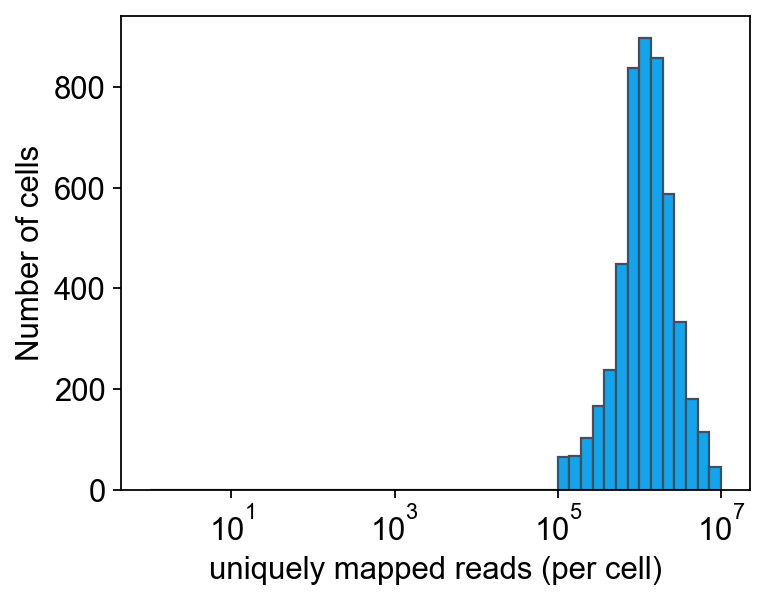

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.hist(counts, bins=np.logspace(0,7,50), edgecolor='#454F59', color='#12A5ED')
ax.set_xscale('log')
ax.grid(False)
ax.set_xlabel("uniquely mapped reads (per cell)", fontsize=14)
ax.set_ylabel("Number of cells", fontsize=14)
plt.tight_layout()
# fig.savefig("../figure_making/figures/figure1/all_new/read_distribution.pdf")

In [13]:
genes = adata_all.obs['n_genes']

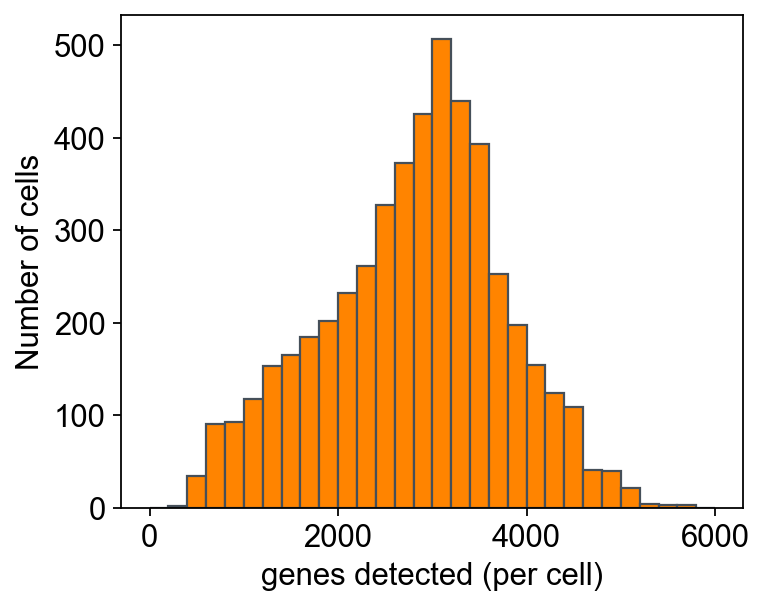

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.hist(genes, bins=np.arange(0,6200,200), range=[0, 6000], edgecolor='#454F59', color='#FF8400')
ax.set_xscale('linear')
ax.grid(False)
ax.set_xlabel("genes detected (per cell)", fontsize=14)
ax.set_ylabel("Number of cells", fontsize=14)
plt.tight_layout()
# fig.savefig("../figure_making/figures/figure1/all_new/gene_distribution_all.pdf")

# plot marker gene expression

In [15]:
genes = ['mCD8-GFP','nSyb','elav','CadN','Syt1','Oaz','brp', 'repo', 'alrm']

In [16]:
sc.set_figure_params(figsize=(5,15))

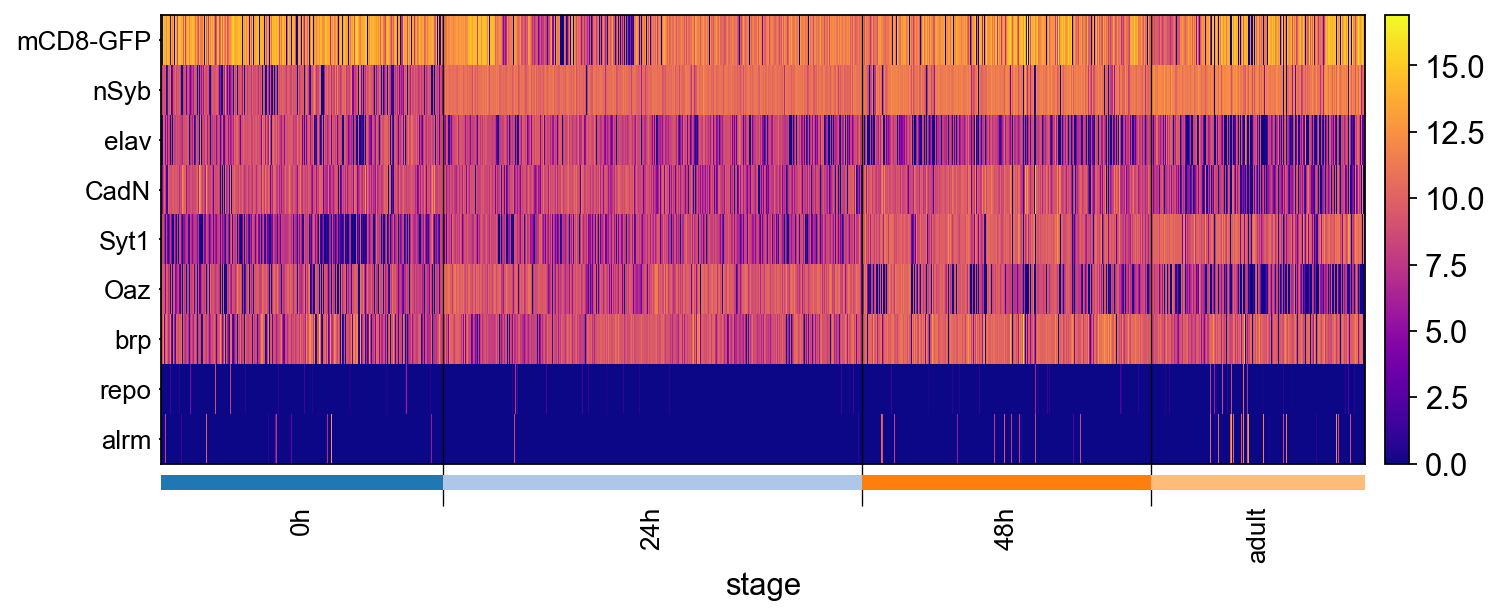

GridSpec(3, 3, height_ratios=[0, 3.87, 0.13], width_ratios=[10, 0, 0.2])

In [18]:
sc.pl.heatmap(adata_all, var_names=genes, groupby='stage', swap_axes=True, cmap="plasma",figsize=(10,4))#, save='_heatmap.pdf')

# plot by overdispersed genes

In [19]:
adata_all.X = np.nan_to_num(adata_all.X)

In [20]:
X = adata_all.to_df().T

In [21]:
# Get top overdispersed genes
myDispersion = sct.dispersion(X)
myDispersion.calc_dispersion() # calculate overdispersion
genes_overdispersed = myDispersion.get_hits(N=500)
Y = X.loc[genes_overdispersed.index]

In [23]:
# Calculate TSNE
from sklearn.manifold import TSNE
myTSNE = sct.TSNE(X.loc[genes_overdispersed.index], X, df_libs)
myTSNE.calc_TSNE(perplexity=40, learning_rate=500)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4944 samples in 0.019s...
[t-SNE] Computed neighbors for 4944 samples in 0.475s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4944
[t-SNE] Computed conditional probabilities for sample 2000 / 4944
[t-SNE] Computed conditional probabilities for sample 3000 / 4944
[t-SNE] Computed conditional probabilities for sample 4000 / 4944
[t-SNE] Computed conditional probabilities for sample 4944 / 4944
[t-SNE] Mean sigma: 0.122038
[t-SNE] Computed conditional probabilities in 0.220s
[t-SNE] Iteration 50: error = 18.1471405, gradient norm = 0.0062306 (50 iterations in 4.853s)
[t-SNE] Iteration 100: error = 17.6178188, gradient norm = 0.0061040 (50 iterations in 2.035s)
[t-SNE] Iteration 150: error = 17.4820957, gradient norm = 0.0014059 (50 iterations in 2.100s)
[t-SNE] Iteration 200: error = 17.4167366, gradient norm = 0.0011193 (50 iterations in 2.171s)
[t-SNE] Iteration 250: error = 17.3793678, gradient norm = 0.001034

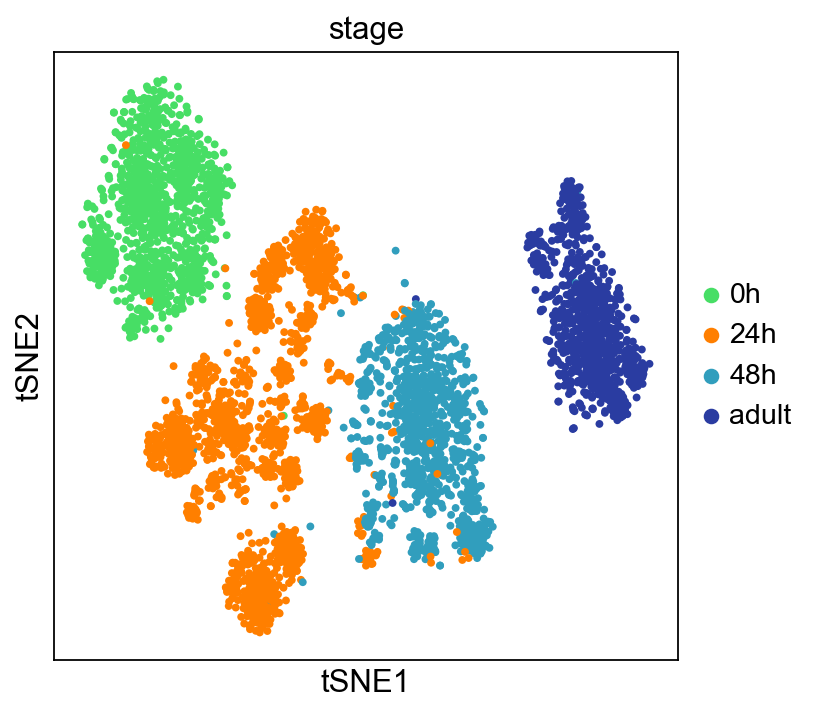

In [24]:
# Note: this is slightly different from the figure due to the parameters used for tSNE
adata_all.uns['stage_colors'] = ['#47de65', '#ff7f00', '#319ebd', '#2A3CA1']
adata_all.obsm['X_tsne'] = myTSNE.X_tsne
sc.set_figure_params(figsize=(5,5))
sc.pl.tsne(adata_all, color='stage', size=(50,50))